In [158]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import cmath
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'w'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'jet'

res = 200
MC_N = int(1e3)

# parameters

In [159]:
Delta_ZPL_0 = 406.83 * 0.  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

sigma = 2.5e-4 # Kelsey
gamma_10 = 28e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

# omega_t = np.linspace(405.5, 408.75, res)
# omega_tau = np.linspace(-408.75, -405.5, res)

omega_t = np.linspace(-0.5, 0.5, res)
omega_tau = np.linspace(-0.5, 0.5, res)

# colorbar function

In [160]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

In [161]:
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')

# multiple plot function

In [162]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'$\omega_t \quad$',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'$\omega_\tau \quad$',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(omega_t), max(omega_t), min(omega_tau), max(omega_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [163]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [164]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phase(x):

    return cmath.phase(x)

\begin{equation}\label{eq:1}
    \Delta_{ZPL}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}) = \Delta_{ZPL,0} + (t_{\parallel,es} - t_{\parallel,gs})\epsilon_{zz} + (t_{\perp,es} - t_{\perp,gs})(\epsilon_{xx} + \epsilon_{yy})
\end{equation}


In [165]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

\begin{equation}\label{eq:2}
    \Delta_{gs}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,gs}^2 + 4[d_{gs}(\epsilon_{xx} - \epsilon_{yy}) + f_{gs} \epsilon_{yz}]^2 + 4[-2d_{gs} \epsilon_{xy} + f_{gs} \epsilon_{zx}]^2}
\end{equation}

In [166]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

\begin{equation}\label{eq:3}
    \Delta_{es}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,es}^2 + 4[d_{es}(\epsilon_{xx} - \epsilon_{yy}) + f_{es} \epsilon_{yz}]^2 + 4[-2d_{es} \epsilon_{xy} + f_{es} \epsilon_{zx}]^2}
\end{equation}

In [167]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

\begin{equation}\label{eq:4}
    \rho (\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \left( \frac{i \sqrt{A} \, \gamma_{10}}{\omega_t-[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} - i \gamma_{10}]} \right ) \left (\frac{i \sqrt{A} \, \gamma_{10}}{\omega_{\tau}+[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} + i \gamma_{10}]} \right)
\end{equation}


In [168]:
@numba.jit
def rho(omega_t,
        omega_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    amp = np.array(
        [0.0938, 0.0833, 0.0579, 0.0576,
         0.0709, 1.0000, 0.0799, 0.1521, 
         0.0631, 0.0837, 0.3036, 0.0737, 
         0.0522, 0.1212, 0.0581, 0.1228])
#     amp = np.array(
#         [0., 1., 1., 1., 
#          1., 1., 1., 1., 
#          1., 1., 1., 1., 
#          1., 1., 1., 1.])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(omega_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            omega_t - (Del_ZPL + sign[i, 0] * Del_gs + sign[i, 1] * Del_es -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            omega_tau + (Del_ZPL + sign[i, 2] * Del_gs + sign[i, 3] * Del_es +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2157/565402565.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7fb699f5f430>)) with parameters (float64, float64, float64, float64, float64)

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7fb699f5f430>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2157/565402565.py (13)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2157/565402565.py", line 13:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2157/565402565.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Lifted

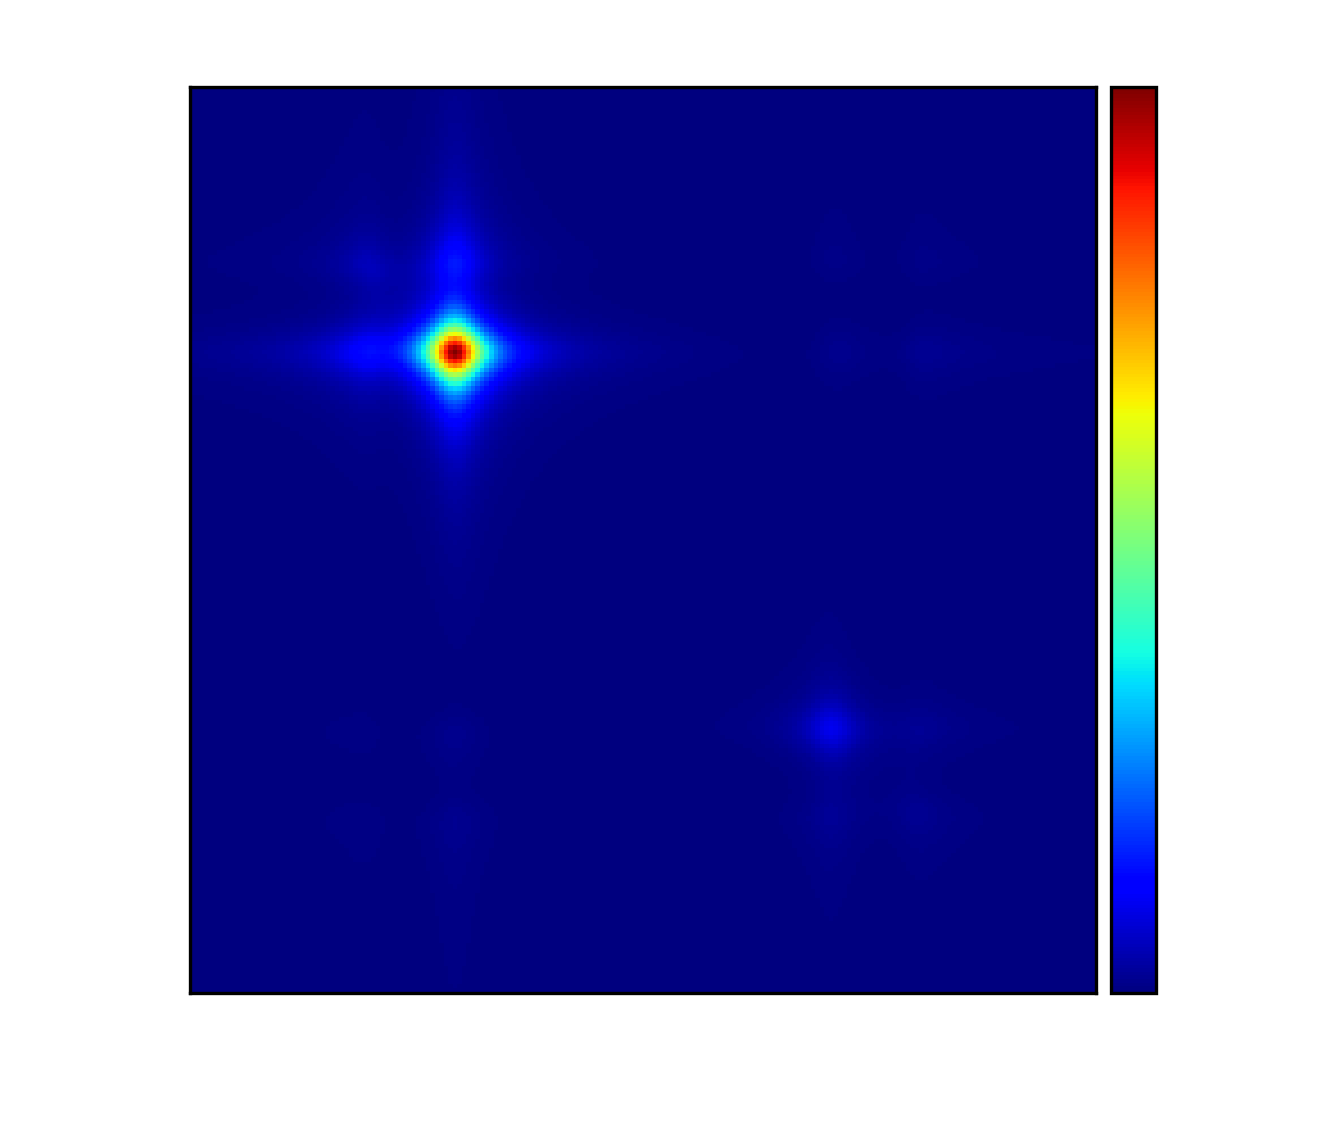

In [169]:
RHO = abs2(rho(omega_t_mesh, omega_tau_mesh))

plt.figure()
im = plt.imshow(RHO, 
                origin='lower', 
                extent=(min(omega_t), 
                        max(omega_t), 
                        min(omega_tau), 
                        max(omega_tau)))
plt.xlabel(r'$\omega_t$')
plt.ylabel(r'$\omega_\tau$')
plt.title(r'$\omega_\tau$ mesh')
colorbar(im)
plt.show()
